# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={"figure.figsize": (14, 8)}, context="talk", style="darkgrid")

# Importing data

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [8]:
print(train_df.shape)
print(test_df.shape)

(8693, 14)
(4277, 13)


## PassengerId

### Train Data

In [9]:
# checking for duplicates
train_df.duplicated().sum()

0

In [10]:
# splitting "PassengerId" into "Group" "Id" 
train_df["Group"] = train_df["PassengerId"].apply(lambda x: x.split("_")[0])
train_df["Id"] = train_df["PassengerId"].apply(lambda x: x.split("_")[1])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [11]:
# dropping "PassengerId" column
train_df = train_df.drop(columns="PassengerId")

train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [12]:
# converting "Group" and "Id" to int64
train_df = train_df.astype({"Group":"int64",
                           "Id":"int64"})
train_df.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Group             int64
Id                int64
dtype: object

In [13]:
train_df["Id"].value_counts()    # groups had a max of 8 people"

1    6217
2    1412
3     571
4     231
5     128
6      75
7      46
8      13
Name: Id, dtype: int64

In [14]:
# Creating "GroupSize" column
train_df["GroupSize"] = 0
for x in train_df["Group"]:
    group_size = len(train_df.loc[train_df["Group"].isin([x])])
    train_df.loc[train_df["Group"].isin([x]), ["GroupSize"]] = group_size

In [15]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


In [16]:
train_df["GroupSize"].value_counts()

1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: GroupSize, dtype: int64

Text(0.5, 1.0, 'Group Sizes')

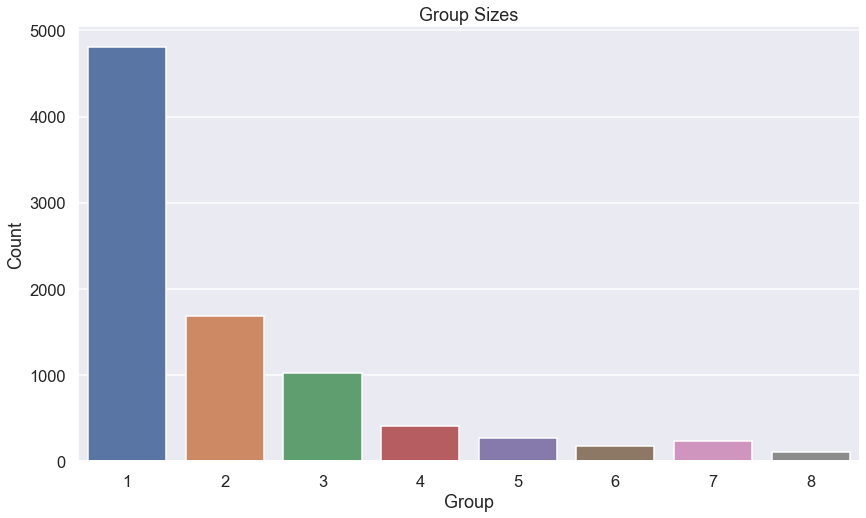

In [17]:
sns.countplot(data=train_df, x="GroupSize")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Group Sizes")

- We can see that majority of the  passengers were traveling alone.

Text(0.5, 1.0, 'Transported Groups')

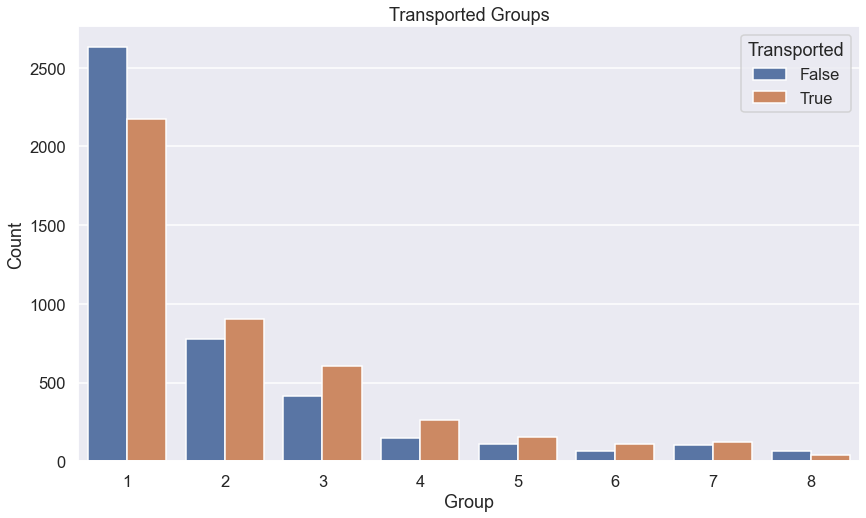

In [18]:
sns.countplot(data=train_df, x="GroupSize", hue="Transported")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Transported Groups")

- From the graph we can see that being part of a group does affect whether a person was transported or not

### Test Data

In [19]:
# Splitting "PassengerId" Column
test_df["Group"] = test_df["PassengerId"].apply(lambda x: x.split("_")[0])
test_df["Id"] = test_df["PassengerId"].apply(lambda x: x.split("_")[1])

test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,01
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,01
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,01
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,01
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,01


In [20]:
# Converting columns to ints
test_df = test_df.astype({"Group":"int64", "Id":"int64"})

# Dropping "PassengerId" column
test_df = test_df.drop(columns="PassengerId")

In [21]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1


In [22]:
# Creating "GroupSize" column
test_df["GroupSize"] = 0
for x in test_df["Group"]:
    group_size = len(test_df.loc[test_df["Group"].isin([x])])
    test_df.loc[test_df["Group"].isin([x]), ["GroupSize"]] = group_size

test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1


In [23]:
test_df["GroupSize"].value_counts()

1    2340
2     908
3     486
4     204
5     115
7      98
6      78
8      48
Name: GroupSize, dtype: int64

Text(0.5, 1.0, 'Group Size')

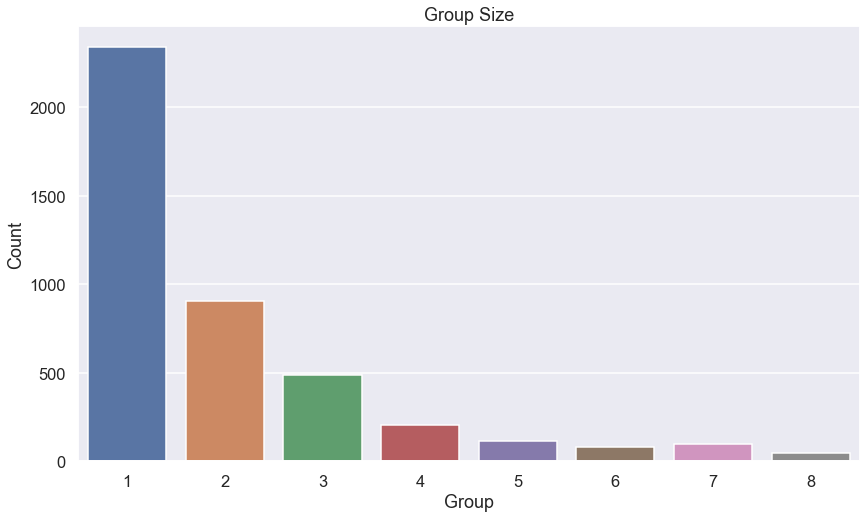

In [24]:
sns.countplot(data=test_df, x="GroupSize")
plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Group Size")

- We see a similar trend in the test data where majority of the travelers were traveling alone.

## Home Planet

### Train Data

In [25]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,1


In [26]:
train_df["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Text(0.5, 1.0, 'Groups Transported by Planet')

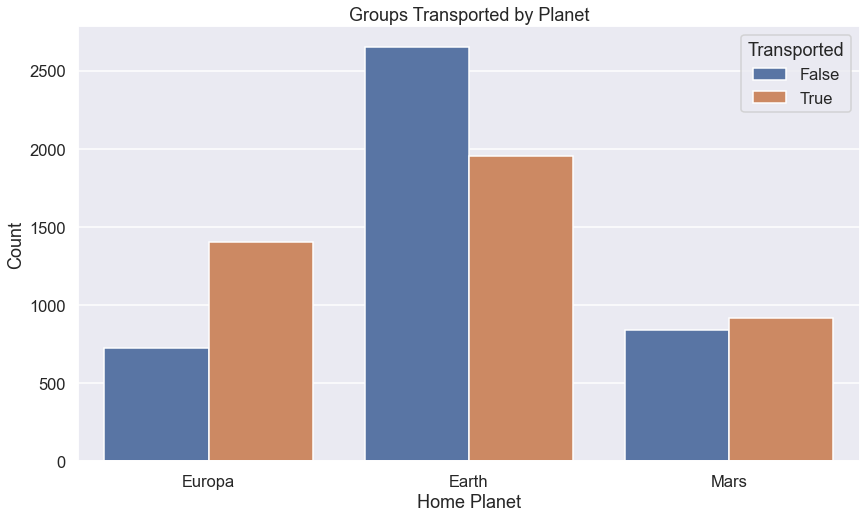

In [27]:
sns.countplot(data=train_df, x="HomePlanet", hue="Transported")
plt.xlabel("Home Planet")
plt.ylabel("Count")
plt.title("Groups Transported by Planet")

In [28]:
train_df.groupby("HomePlanet")["Transported"].mean()

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64

- Earth: From the graph we can see that most people on board the ship were from planet Earth and about 42% were transported to another dimension.

- Europa: We can see that about 65% of the people who are traveling from Europa were transported to another dimension

- Mars: As for Mars about 52% were transported to another dimension, almost half.

- Conclusion: We can see that being from Europa and Mars indicates a higher chance of being transported.

### Test Data

Text(0.5, 1.0, 'Travelers Home Planets')

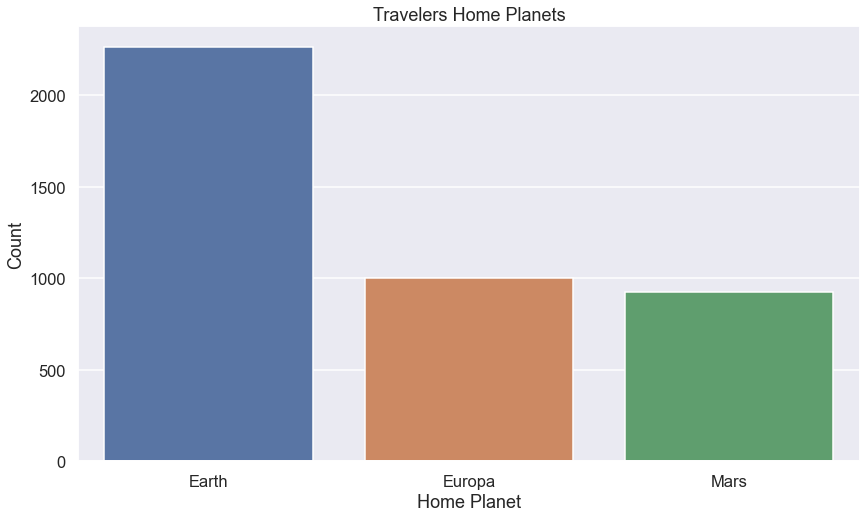

In [29]:
sns.countplot(data=test_df, x="HomePlanet")
plt.xlabel("Home Planet")
plt.ylabel("Count")
plt.title("Travelers Home Planets")

- The test data also follows a similar trend where most travelers are from Earth with Europa following second and Mars coming in last

## CryoSleep

### Train Data

In [30]:
# Converting "CryoSleep" into bool type
train_df = train_df.astype({"CryoSleep": "bool"})
train_df["CryoSleep"].dtype

dtype('bool')

In [31]:
train_df["CryoSleep"].value_counts()

False    5439
True     3254
Name: CryoSleep, dtype: int64

Text(0.5, 1.0, 'Transported Passengers in CryoSleep')

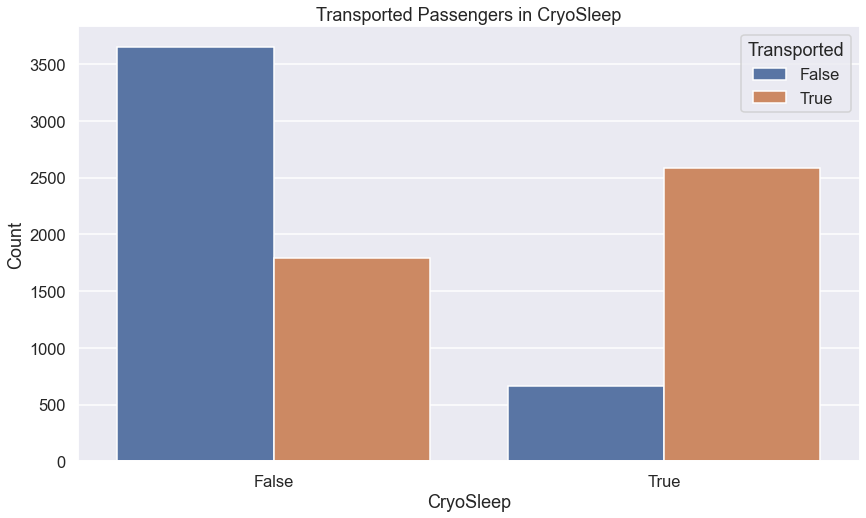

In [32]:
sns.countplot(data=train_df, x="CryoSleep", hue="Transported")
plt.xlabel("CryoSleep")
plt.ylabel("Count")
plt.title("Transported Passengers in CryoSleep")

- From the graph we can clearly see that majority of passengers confined to cryosleep were transported to another dimension.

### Test Data

In [33]:
test_df["CryoSleep"].value_counts()

False    2640
True     1544
Name: CryoSleep, dtype: int64

Text(0.5, 1.0, 'Passengers in CryoSleep')

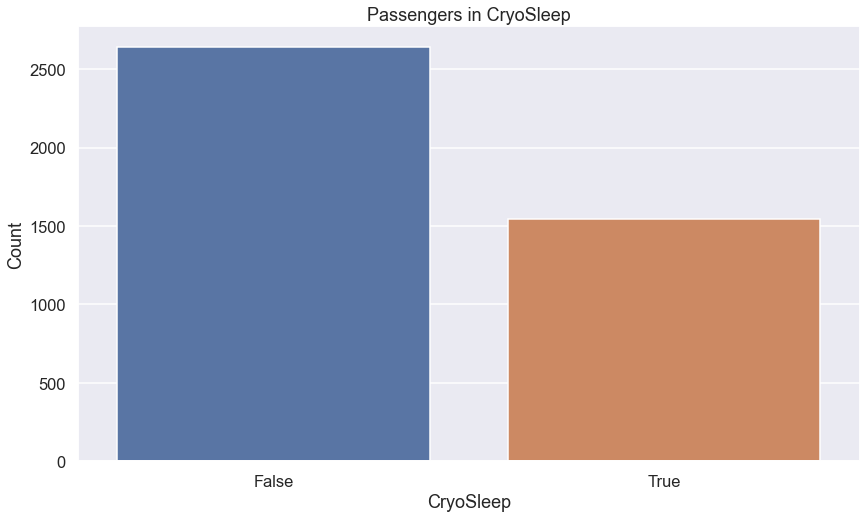

In [34]:
sns.countplot(data=test_df, x="CryoSleep")
plt.xlabel("CryoSleep")
plt.ylabel("Count")
plt.title("Passengers in CryoSleep")

- We can see that majority of travelers did were not under cryosleep

## CryoSleep and Cabin Location

- Since travelers under cryosleep were confined to their cabins, and majority of those under cryosleep were transported to another dimension we are going to examine their cabin locations to see if there is any correlation between the location of the cabin and being transported to another dimension.

### Train Data

In [35]:
cryo_filter = train_df["CryoSleep"] == True
transported_filter = train_df["Transported"] == True

cryo_trans = train_df.loc[cryo_filter & transported_filter, :].copy()

cryo_trans.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,2,2
9,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,8,1,3
10,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8,2,3
18,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True,16,1,1
28,Europa,True,C/2/S,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True,24,1,1


In [37]:
# Since cabin has null values we are going to replace them with "N/A"
cryo_trans["Cabin"] = cryo_trans["Cabin"].fillna("N/A")
cryo_trans["Cabin"].isnull().sum()

0

In [43]:
# splitting "Cabin" which is in "deck/num/side" 
cryo_trans["Side"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[-1])
cryo_trans["DeckNumber"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[1])
cryo_trans["Deck"] = cryo_trans["Cabin"].apply(lambda x: x.split("/")[0])

# Dropping "Cabin" column
cryo_trans = cryo_trans.drop(columns="Cabin")
cryo_trans.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,GroupSize,Side,DeckNumber,Deck
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,2,2,S,0,G
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,8,1,3,P,1,B
10,Europa,True,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8,2,3,P,1,B
18,Mars,True,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True,16,1,1,P,5,F
28,Europa,True,TRAPPIST-1e,62.0,False,0.0,0.0,NaN,0.0,0.0,Penton Fullided,True,24,1,1,S,2,C


In [44]:
cryo_trans["Deck"].value_counts()

G    919
F    572
B    428
C    309
E    116
D    106
N     71
A     68
Name: Deck, dtype: int64

Text(0.5, 1.0, 'Travelers Transported by Location')

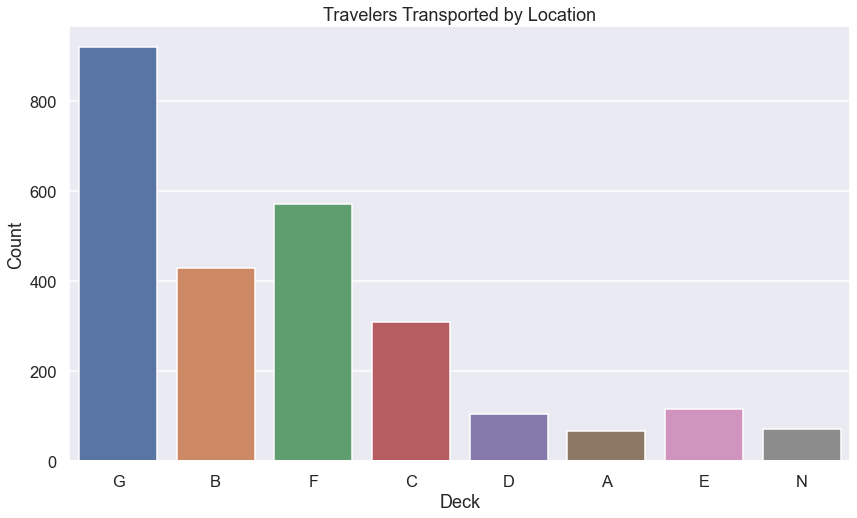

In [45]:
sns.countplot(data=cryo_trans, x="Deck")
plt.xlabel("Deck")
plt.ylabel("Count")
plt.title("Travelers Transported by Location")

- From the graph we can see that those who were in cryosleep on decks [G, B, F, C] were more likely to have gotten teleported to another dimension. 

In [59]:
cryo_trans["Side"].value_counts()

S    1369
P    1149
A      71
Name: Side, dtype: int64

Text(0.5, 1.0, 'Transported Travelers by Deck Side')

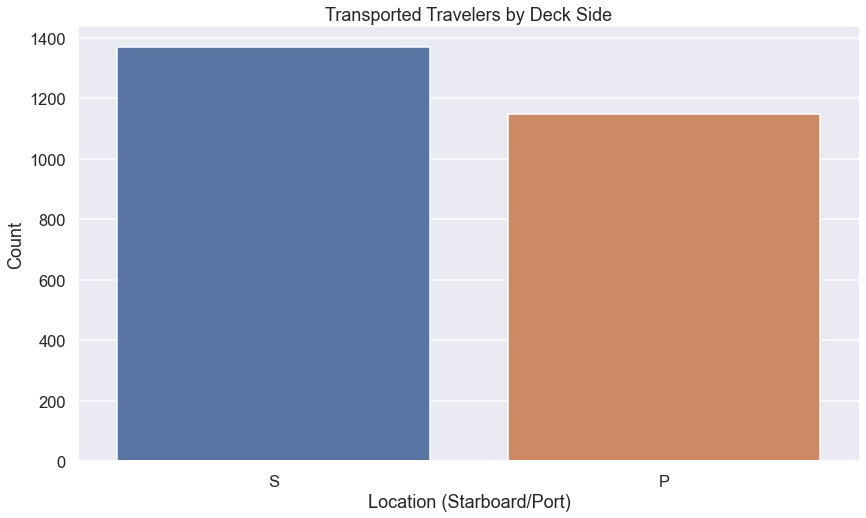

In [80]:
sns.countplot(data=cryo_trans.loc[cryo_trans["Side"] != "A"], x="Side")
plt.xlabel("Location (Starboard/Port)")
plt.ylabel("Count")
plt.title("Transported Travelers by Deck Side")

- We can see that more travelers located at the Starboard side of the ship were transported but not enough to determine a difference.

### Test Data

In [82]:
test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Id,GroupSize
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,1,1
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,1,1
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,1,1
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,1,1
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,1,1
